In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os,pickle
import librosa,cv2,shutil
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.constraints import max_norm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation

In [2]:
warnings.filterwarnings('ignore')
df = pd.read_csv('/kaggle/input/iemocap-emotion-speech-database/iemocap_full_dataset.csv')
df

,session,method,gender,emotion,n_annotators,agreement,path
0,1,script,F,neu,3,3,Session1/sentences/wav/Ses01F_script02_1/Ses01...
1,1,script,F,fru,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...
2,1,script,F,xxx,0,0,Session1/sentences/wav/Ses01F_script02_1/Ses01...
3,1,script,F,sur,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...
4,1,script,F,neu,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...
...,...,...,...,...,...,...,...
10034,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...
10035,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...
10036,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...
10037,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...


In [3]:
df['emotion'].value_counts()

emotion
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: count, dtype: int64

In [4]:
df2 = df[df['emotion'].isin(['neu','ang','sad','exc','hap'])]
df2.loc[df2['emotion'] == 'exc', 'emotion'] = 'hap'
df2.reset_index(drop=True,inplace=True)
print(df2.shape)
df2['emotion'].value_counts()

(5531, 7)


emotion
neu    1708
hap    1636
ang    1103
sad    1084
Name: count, dtype: int64

In [5]:
extpath = lambda x:x.split('/')[-1]
df2.loc[:, 'File_Name'] = df2['path'].apply(extpath)
labdict = dict(zip(df2['File_Name'], df2['emotion']))

In [6]:
!pip install noisereduce

In [7]:
import torchaudio
import noisereduce as nr
import IPython.display as ipd
import numpy as np
dpath = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session3/sentences/wav/'
randf = np.random.choice(os.listdir(dpath))
path2 = os.path.join(dpath,randf)
randw = np.random.choice(os.listdir(path2))
audio_path = os.path.join(path2,randw)
y, sr = librosa.load(audio_path,sr=16000)
ipd.Audio(y, rate=sr)

In [8]:
rn = nr.reduce_noise(y=y, sr=sr)
ipd.Audio(rn, rate=sr)

In [9]:
def compute_snr(clean_audio, noisy_audio):
    signal_power = np.mean(clean_audio**2)
    noise = noisy_audio - clean_audio
    noise_power = np.mean(noise**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr
compute_snr(rn,y)

-2.6190924644470215

In [11]:
def load_preprocess_extract_features(wavpath):
    features = {}
    audio,sr = librosa.load(wavpath,sr=16000)
    audio, _ = librosa.effects.trim(audio,top_db=20)
    audio = nr.reduce_noise(y=audio, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).mean(axis=1)
    for i, value in enumerate(mfcc):
        features[f'mfcc{i+1}'] = value

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(chroma):
        features[f'chroma{i+1}'] = value

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(spectral_contrast):
        features[f'spectral_contrast{i+1}'] = value

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).mean(axis=1)
    for i, value in enumerate(tonnetz):
        features[f'tonnetz{i+1}'] = value
    return features

In [12]:
c = 0
feats = []
for sess in range (1,6):
    wav_file_path = f'/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session{sess}/sentences/wav/'
    wav_folders = os.listdir(wav_file_path)
    for folder in wav_folders:
        fol_path = os.path.join(wav_file_path,folder)
        for wav in os.listdir(fol_path):
            if wav[-4:]=='.wav':
                if wav in labdict.keys():
                    wavpath = os.path.join(fol_path,wav)
                    feat = load_preprocess_extract_features(wavpath)
                    c+=1
                    print(f"{c}/{df2.shape[0]} - {c/df2.shape[0]*100:.2f}%")
                    clear_output(wait=True)
                    feat['label'] = labdict[wav]
                    feats.append(feat)

5531/5531 - 100.00%


In [13]:
df3 = pd.DataFrame(feats)
df3

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,spectral_contrast5,spectral_contrast6,spectral_contrast7,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,tonnetz6,label
0,-531.469543,70.996384,24.289909,37.130524,11.040465,13.429672,-10.408956,9.234770,3.033351,4.706578,...,41.759185,32.799925,32.824491,-0.013406,0.027340,-0.063669,-0.060761,-0.007241,-0.002479,hap
1,-296.565674,63.583500,-29.345579,-4.472399,-12.874627,-6.588418,-17.790037,-0.734459,-7.140967,-3.291160,...,32.311330,33.811254,27.959841,0.004459,-0.026533,-0.037201,-0.005310,-0.002735,0.015463,hap
2,-425.393372,64.611725,-5.628653,4.907248,-6.341900,-5.900495,-22.331976,-18.388199,-17.528366,-5.826988,...,33.914708,38.781664,32.665988,-0.017530,0.009397,0.032661,-0.073044,-0.022444,-0.027235,hap
3,-485.985535,81.998642,-14.296952,12.400829,-9.557034,-16.055355,-19.032717,-10.934519,-6.073104,1.379356,...,35.471898,40.588257,39.586396,-0.040091,-0.010479,-0.018630,-0.069136,-0.007288,-0.032080,hap
4,-372.224701,72.500206,-33.745865,-3.283597,-21.188143,-14.334318,-26.033096,-14.806952,-12.331807,-8.430577,...,30.044462,44.137722,45.740002,0.046572,-0.021082,0.067702,-0.000495,-0.011582,-0.014994,hap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,-660.490967,30.096292,5.989079,19.971521,-6.340953,1.281596,-6.128734,0.691296,-2.699449,3.595718,...,21.346046,24.400202,33.304831,-0.009080,0.013348,-0.007568,-0.045513,-0.014076,-0.013464,sad
5527,-604.977966,121.800392,-14.806895,37.024250,-20.087963,29.533115,-13.827265,14.362831,6.730567,-0.473424,...,27.116371,30.568890,16.958251,0.047847,0.033999,-0.130765,0.074053,-0.017805,-0.023573,hap
5528,-574.210693,41.987686,-1.729624,19.536690,-0.596501,0.114694,-9.045651,-6.101354,-6.407043,-1.356042,...,29.285427,33.121149,36.115920,-0.004333,0.005258,0.027371,-0.001035,-0.004833,0.003488,hap
5529,-454.469391,75.403969,-10.331232,32.191322,-20.591536,5.771362,-8.142285,-9.612243,-12.282533,1.858377,...,30.246386,46.538844,38.759385,-0.013344,0.034243,-0.031079,-0.021639,-0.016630,-0.015865,hap


In [14]:
df3.to_csv('/kaggle/working/iemocapmfccfeatures_noisereduced.csv')

In [15]:
xmfcc = df3.iloc[:,:20]
xchr = df3.iloc[:,20:32]
xspc = df3.iloc[:,32:39]
xton = df3.iloc[:,39:-1]
xall = df3.drop('label',axis=1)
y = df3['label']

In [16]:
def scale_n_split(feat,y):
    scaler = StandardScaler()
    x = scaler.fit_transform(feat)
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)
    return trainX, testX, trainY, testY
def traintestmodel(feat,y,title):
    trainX, testX, trainY, testY = scale_n_split(feat,y)
    lr_model = LogisticRegression(random_state=42)
    lr_model.fit(trainX, trainY)
    lr_predictions = lr_model.predict(testX)
    acc_lr = accuracy_score(testY, lr_predictions)
    print(f"Logistic Regression Accuracy: {acc_lr*100:.3f}%")
    print(classification_report(testY, lr_predictions))

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(trainX, trainY)
    dt_predictions = dt_model.predict(testX)
    acc_dt = accuracy_score(testY, dt_predictions)
    print(f"Decision Tree Accuracy: {acc_dt*100:.3f}%")
    print(classification_report(testY, dt_predictions))

    rf_model = RandomForestClassifier(n_estimators=400,random_state=42)
    rf_model.fit(trainX, trainY)
    rf_predictions = rf_model.predict(testX)
    acc_rf = accuracy_score(testY, rf_predictions)
    print(f"Random Forest Accuracy: {acc_rf*100:.3f}%")
    print(classification_report(testY, rf_predictions))

    svm_model = SVC(random_state=42)
    svm_model.fit(trainX, trainY)
    svm_predictions = svm_model.predict(testX)
    acc_svm = accuracy_score(testY, svm_predictions)
    print(f"SVM Accuracy: {acc_svm*100:.3f}%")
    print(classification_report(testY, svm_predictions))

    knn_model = KNeighborsClassifier()
    knn_model.fit(trainX, trainY)
    knn_predictions = knn_model.predict(testX)
    acc_knn = accuracy_score(testY, knn_predictions)
    print(f"KNN Accuracy: {acc_knn*100:.3f}%")
    print(classification_report(testY, knn_predictions))
    
    models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN']
    accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn]
    plt.figure(figsize=(8, 4))
    bars = plt.bar(models, accuracies)
    for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
    plt.title(f'Accuracy Comparison of Different Models using {title} features')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()
    return accuracies

Logistic Regression Accuracy: 57.814%
              precision    recall  f1-score   support

         ang       0.69      0.61      0.64       221
         hap       0.52      0.49      0.50       327
         neu       0.54      0.63      0.58       342
         sad       0.65      0.60      0.62       217

    accuracy                           0.58      1107
   macro avg       0.60      0.58      0.59      1107
weighted avg       0.58      0.58      0.58      1107

Decision Tree Accuracy: 44.083%
              precision    recall  f1-score   support

         ang       0.46      0.47      0.46       221
         hap       0.39      0.38      0.39       327
         neu       0.45      0.47      0.46       342
         sad       0.49      0.46      0.47       217

    accuracy                           0.44      1107
   macro avg       0.45      0.44      0.44      1107
weighted avg       0.44      0.44      0.44      1107

Random Forest Accuracy: 59.440%
              precision    r

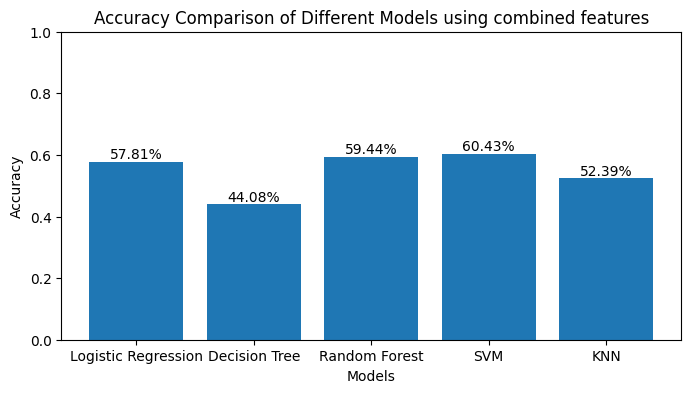

In [17]:
acc_com = traintestmodel(xall,y,'combined')

Logistic Regression Accuracy: 53.297%
              precision    recall  f1-score   support

         ang       0.66      0.58      0.62       221
         hap       0.46      0.48      0.47       327
         neu       0.50      0.57      0.53       342
         sad       0.59      0.51      0.55       217

    accuracy                           0.53      1107
   macro avg       0.55      0.53      0.54      1107
weighted avg       0.54      0.53      0.53      1107

Decision Tree Accuracy: 41.283%
              precision    recall  f1-score   support

         ang       0.46      0.43      0.44       221
         hap       0.36      0.40      0.38       327
         neu       0.43      0.42      0.42       342
         sad       0.44      0.41      0.42       217

    accuracy                           0.41      1107
   macro avg       0.42      0.41      0.42      1107
weighted avg       0.42      0.41      0.41      1107

Random Forest Accuracy: 57.453%
              precision    r

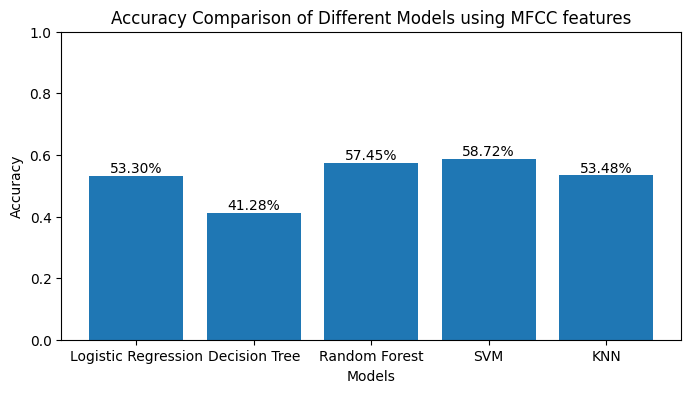

In [18]:
acc_mfcc = traintestmodel(xmfcc,y,'MFCC')

Logistic Regression Accuracy: 38.663%
              precision    recall  f1-score   support

         ang       0.38      0.10      0.15       221
         hap       0.36      0.54      0.43       327
         neu       0.38      0.44      0.40       342
         sad       0.49      0.37      0.42       217

    accuracy                           0.39      1107
   macro avg       0.40      0.36      0.35      1107
weighted avg       0.39      0.39      0.37      1107

Decision Tree Accuracy: 32.520%
              precision    recall  f1-score   support

         ang       0.25      0.25      0.25       221
         hap       0.34      0.31      0.33       327
         neu       0.33      0.35      0.34       342
         sad       0.37      0.38      0.38       217

    accuracy                           0.33      1107
   macro avg       0.32      0.32      0.32      1107
weighted avg       0.33      0.33      0.33      1107

Random Forest Accuracy: 39.566%
              precision    r

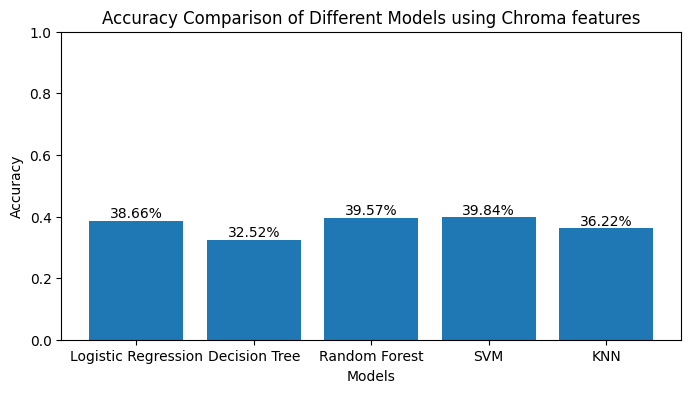

In [19]:
acc_chr = traintestmodel(xchr,y,'Chroma')

Logistic Regression Accuracy: 41.012%
              precision    recall  f1-score   support

         ang       0.44      0.10      0.16       221
         hap       0.35      0.45      0.40       327
         neu       0.43      0.51      0.47       342
         sad       0.48      0.50      0.49       217

    accuracy                           0.41      1107
   macro avg       0.42      0.39      0.38      1107
weighted avg       0.42      0.41      0.39      1107

Decision Tree Accuracy: 34.417%
              precision    recall  f1-score   support

         ang       0.29      0.29      0.29       221
         hap       0.30      0.29      0.29       327
         neu       0.41      0.41      0.41       342
         sad       0.35      0.38      0.36       217

    accuracy                           0.34      1107
   macro avg       0.34      0.34      0.34      1107
weighted avg       0.34      0.34      0.34      1107

Random Forest Accuracy: 43.180%
              precision    r

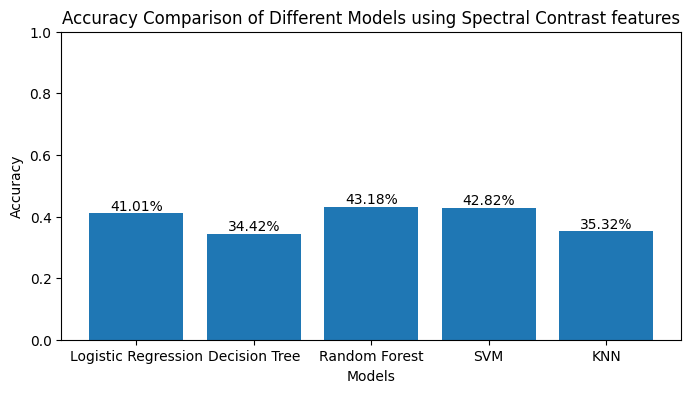

In [20]:
acc_spc = traintestmodel(xspc,y,'Spectral Contrast')

Logistic Regression Accuracy: 33.333%
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       221
         hap       0.31      0.45      0.37       327
         neu       0.35      0.59      0.44       342
         sad       0.38      0.08      0.14       217

    accuracy                           0.33      1107
   macro avg       0.26      0.28      0.24      1107
weighted avg       0.27      0.33      0.27      1107

Decision Tree Accuracy: 26.558%
              precision    recall  f1-score   support

         ang       0.21      0.20      0.21       221
         hap       0.33      0.35      0.34       327
         neu       0.30      0.30      0.30       342
         sad       0.16      0.15      0.16       217

    accuracy                           0.27      1107
   macro avg       0.25      0.25      0.25      1107
weighted avg       0.26      0.27      0.26      1107

Random Forest Accuracy: 29.359%
              precision    r

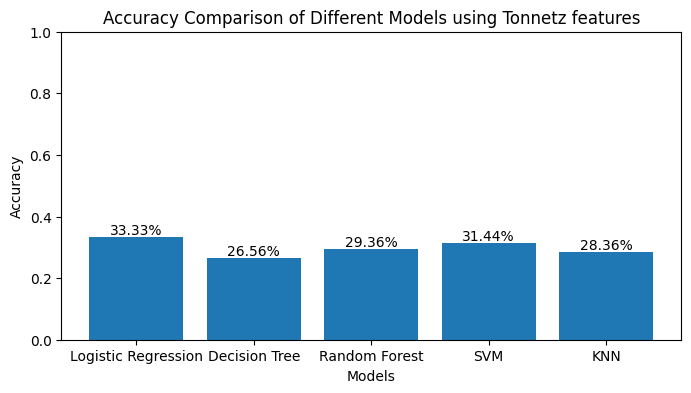

In [21]:
acc_ton = traintestmodel(xton,y,'Tonnetz')

Logistic Regression Accuracy: 55.465%
              precision    recall  f1-score   support

         ang       0.63      0.60      0.62       221
         hap       0.52      0.46      0.49       327
         neu       0.51      0.58      0.55       342
         sad       0.61      0.60      0.61       217

    accuracy                           0.55      1107
   macro avg       0.57      0.56      0.56      1107
weighted avg       0.56      0.55      0.55      1107

Decision Tree Accuracy: 43.089%
              precision    recall  f1-score   support

         ang       0.45      0.47      0.46       221
         hap       0.37      0.39      0.38       327
         neu       0.47      0.45      0.46       342
         sad       0.45      0.42      0.44       217

    accuracy                           0.43      1107
   macro avg       0.44      0.43      0.43      1107
weighted avg       0.43      0.43      0.43      1107

Random Forest Accuracy: 59.530%
              precision    r

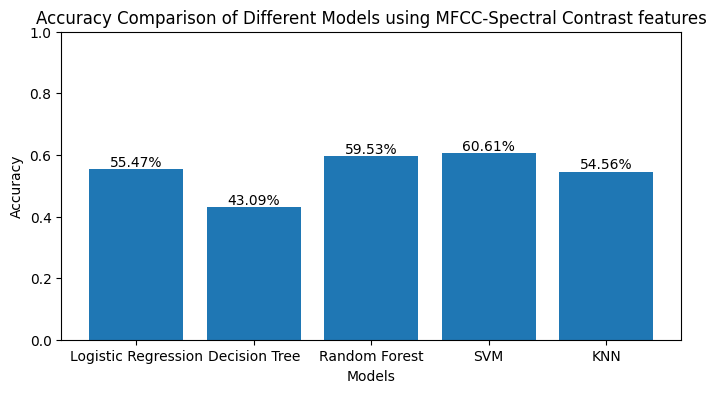

In [22]:
xmfccspc = df3.iloc[:,[i for i in range(20)]+[i for i in range(32,39)]]
acc_mfccspc = traintestmodel(xmfccspc,y,'MFCC-Spectral Contrast')

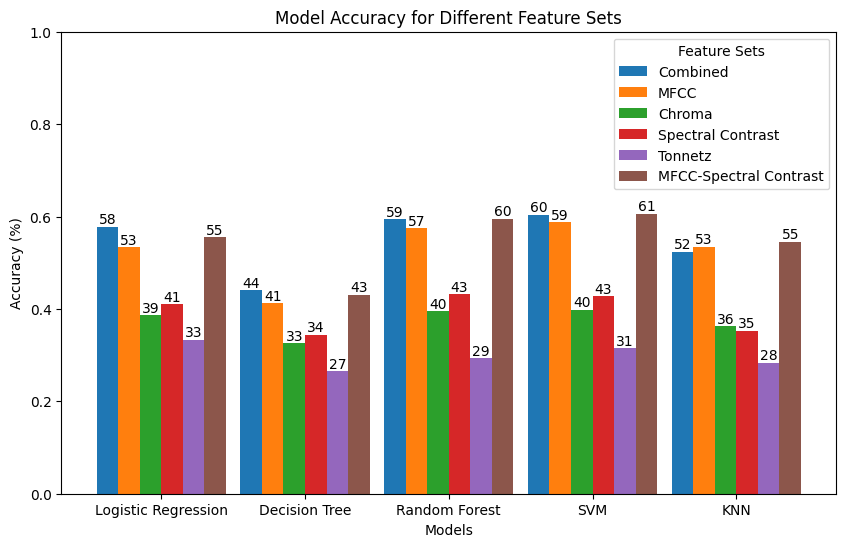

In [23]:
feat_accs = [acc_com,acc_mfcc,acc_chr,acc_spc,acc_ton,acc_mfccspc]
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN']
feat_names = ['Combined','MFCC','Chroma','Spectral Contrast','Tonnetz','MFCC-Spectral Contrast']
num_features = len(feat_accs)
num_models = len(models)
x = np.arange(num_models)
bar_width = 0.15
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_features):
    bars = ax.bar(x + i * bar_width, feat_accs[i], width=bar_width, label=feat_names[i])
    for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.0f}', ha='center', va='bottom')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy for Different Feature Sets')
ax.set_xticks(x + bar_width * (num_features - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylim(0,1)
ax.legend(title='Feature Sets')
plt.show()

In [24]:
trainX, testX, trainY, testY = scale_n_split(xmfccspc,y)

In [33]:
import shutil
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/kaggle/working/best_ann_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/kaggle/working/best_ann_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)
print(f"Model saved with accuracy in filename: {new_mpath}")

Epoch 1/300
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3559 - loss: 1.3006
Epoch 1: val_accuracy improved from -inf to 0.51581, saving model to /kaggle/working/best_ann_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3563 - loss: 1.3001 - val_accuracy: 0.5158 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 2/300
109/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4613 - loss: 1.1524
Epoch 2: val_accuracy improved from 0.51581 to 0.54562, saving model to /kaggle/working/best_ann_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4637 - loss: 1.1489 - val_accuracy: 0.5456 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 3/300
125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4958 - loss: 1.0749
Epoch 3: val_accuracy did not improve from 0.54562
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4965 - loss: 1.0762 - val_accuracy: 0.5375 - val_loss: 1.0374 - learning_rate: 0.0010
Epoch 4/300
127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [74]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=256, step=2),
                    activation='relu', input_shape=(trainX.shape[1],)))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0.0, max_value=0.6, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=2),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.6, step=0.1)))
    
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(),'SGD': SGD(),'RMSprop': RMSprop(),'Adadelta': Adadelta(),
                      'Adagrad': Adagrad(),'Adamax': Adamax(),'Nadam': Nadam(),'Ftrl': Ftrl()}
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))
    model.compile(optimizer=optimizer_dict[selected_optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='ANN_HP_Tuning2'
)
callbackshpt = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)]
tuner.search(trainX, trainY_enc, epochs=500, batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [i for i in range(16,132,4)]),validation_data=(testX, testY_enc),callbacks=callbackshpt)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Trial 10 Complete [00h 00m 26s]
val_accuracy: 0.30894309282302856

Best val_accuracy So Far: 0.6169828176498413
Total elapsed time: 00h 10m 50s
Best hyperparameters: {'units_input': 226, 'dropout_rate_input': 0.5, 'num_layers': 2, 'units_0': 26, 'dropout_rate_0': 0.0, 'optimizer': 'SGD', 'batch_size': 44, 'units_1': 106, 'dropout_rate_1': 0.2, 'units_2': 174, 'dropout_rate_2': 0.0}
Best trial ID: 05


In [75]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 226)            │         6,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 226)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         5,902 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 106)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,520 (60.62 KB)

 Trainable params: 15,520 (60.62 KB)

 Non-trainable params: 0 (0.00 B)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.8945 

Accuracy: 61.70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Accuracy: 61.70
              precision    recall  f1-score   support

         ang       0.71      0.63      0.67       221
         hap       0.59      0.54      0.56       327
         neu       0.59      0.70      0.64       342
         sad       0.63      0.60      0.61       217

    accuracy                           0.62      1107
   macro avg       0.63      0.62      0.62      1107
weighted avg       0.62      0.62      0.62      1107



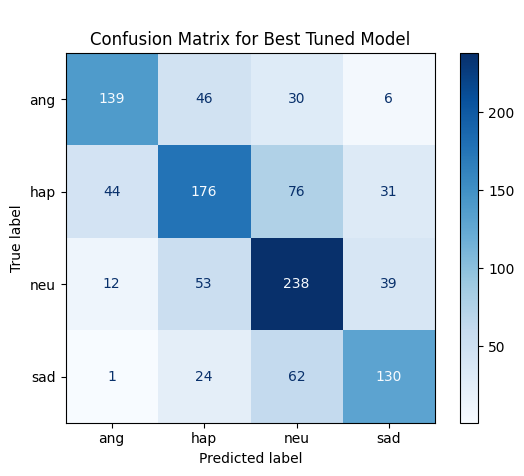

In [86]:
_, accuracy = best_model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))
predictions = best_model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
accuracy = accuracy_score(testY,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(testY, predicted_labels))
cm = confusion_matrix(testY, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_ann_model_hptuned_val_acc_{accuracy*100:.2f}.keras"
best_model.save(new_mpath)

In [12]:
def load_preprocess_extract_specs(wavpath):
    features = {}
    audio,sr = librosa.load(wavpath,sr=16000)
    audio, _ = librosa.effects.trim(audio,top_db=20)
    audio = nr.reduce_noise(y=audio, sr=sr)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize=[6,6])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')
    filename  = 'temp.jpg'
    plt.savefig(filename, dpi = 400, bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = cv2.resize(image.numpy(),(256,256))
    os.remove(filename)
    return image

In [148]:
c = 0
specs,labelss = [],[]
for sess in range (1,6):
    wav_file_path = f'/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session{sess}/sentences/wav/'
    wav_folders = os.listdir(wav_file_path)
    for folder in wav_folders:
        fol_path = os.path.join(wav_file_path,folder)
        for wav in os.listdir(fol_path):
            if wav[-4:]=='.wav':
                if wav in labdict.keys():
                    c+=1
                    print(f"{c}/{df2.shape[0]} - {c/df2.shape[0]*100:.2f}%")
                    clear_output(wait=True)
                    label = labdict[wav]
                    wav_path = os.path.join(fol_path,wav)
                    image = load_preprocess_extract_specs(wav_path)
                    specs.append(image)
                    labelss.append(label)
specs = np.array(specs)
labelss = np.array(labelss)

5531/5531 - 100.00%


In [149]:
specsnlabs = specs,labelss
with open('/kaggle/working/specsnlabs_IEMOCAP_256_NR_16Hz.pkl', 'wb') as f:
    pickle.dump(specsnlabs, f)

In [150]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'specsnlabs_IEMOCAP_256_NR_16Hz.pkl')

/kaggle/working


/kaggle/working/specsnlabs_IEMOCAP_256_NR_16Hz.pkl

In [11]:
fpath = '/kaggle/input/iemocap-spectrograms-256x256-4-classes/specsnlabs_IEMOCAP_256_NR_16Hz (1).pkl'
with open(fpath,'rb') as f:
    specs,labelss = pickle.load(f)

In [ ]:
def create_cnn_model():
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256,256,3)))
  model.add(Conv2D(16, (3, 3), activation='relu')
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, (7, 7), activation='relu'))
  model.add(Conv2D(64, (7, 7), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(32, activation='relu',kernel_constraint=max_norm(2.)))
  model.add(Dense(32, activation='relu',kernel_constraint=max_norm(2.)))
  model.add(Dropout(0.5))
  model.add(Dense(len(np.unique(labelss)), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.005, momentum=0.9), metrics=['accuracy'])
  return model

In [41]:
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(labelss))
X_train, X_test, y_train, y_test = train_test_split(specs, y_enc, test_size=0.2, random_state=2,stratify=y_enc)
print(pd.Series(np.argmax(y_train, axis=1)).value_counts()/len(y_train))
print(pd.Series(np.argmax(y_test, axis=1)).value_counts()/len(y_test))

2    0.308770
1    0.295886
0    0.199367
3    0.195976
Name: count, dtype: float64
2    0.308943
1    0.295393
0    0.199639
3    0.196025
Name: count, dtype: float64


Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3357 - loss: 1.3578

I0000 00:00:1727038955.078135     336 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 280 bytes spill stores, 280 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 256 bytes spill stores, 256 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 20 bytes spill stores, 20 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.32972, saving model to /kaggle/working/best_cnn_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - accuracy: 0.3359 - loss: 1.3574 - val_accuracy: 0.3297 - val_loss: 1.3259 - learning_rate: 0.0050
Epoch 2/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3696 - loss: 1.2855
Epoch 2: val_accuracy improved from 0.32972 to 0.35863, saving model to /kaggle/working/best_cnn_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.3695 - loss: 1.2854 - val_accuracy: 0.3586 - val_loss: 1.3519 - learning_rate: 0.0050
Epoch 3/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3913 - loss: 1.2619
Epoch 3: val_accuracy did not improve from 0.35863
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.3914 - loss: 1.2616 - val_accuracy: 0.3080 - val_loss: 1.4299 - learning_rate: 0.0050
Epoch 4/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4061 - loss: 1.2410
Epoch 4: val_accuracy did not improve from 0.3

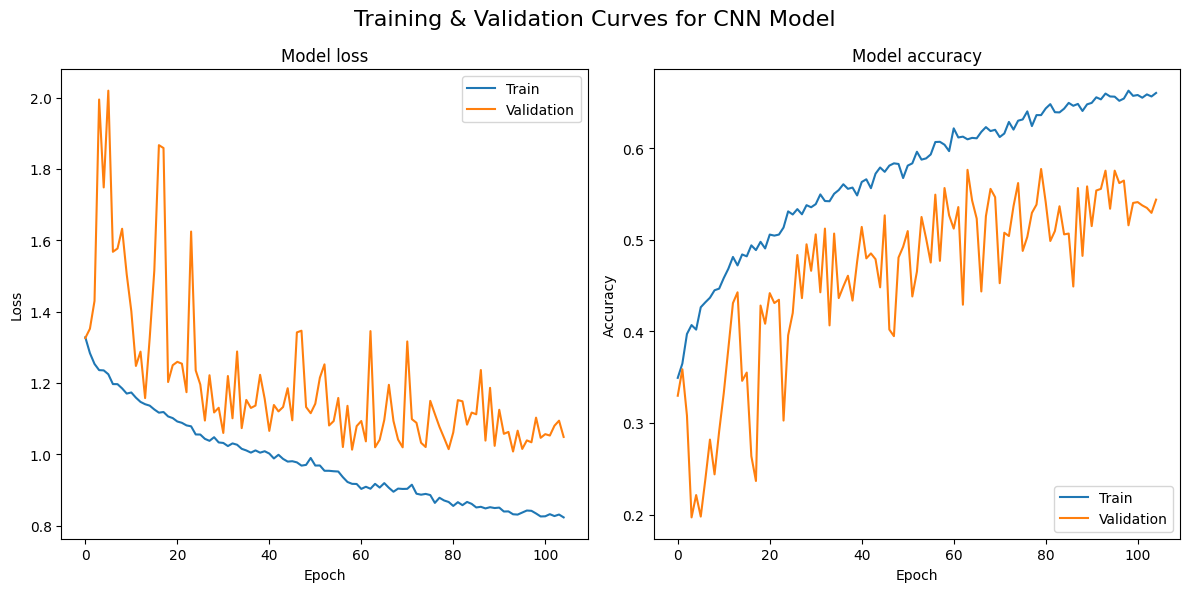

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Accuracy: 57.72
              precision    recall  f1-score   support

         ang       0.76      0.45      0.56       221
         hap       0.52      0.56      0.54       327
         neu       0.58      0.59      0.59       342
         sad       0.55      0.72      0.63       217

    accuracy                           0.58      1107
   macro avg       0.61      0.58      0.58      1107
weighted avg       0.59      0.58      0.58      1107



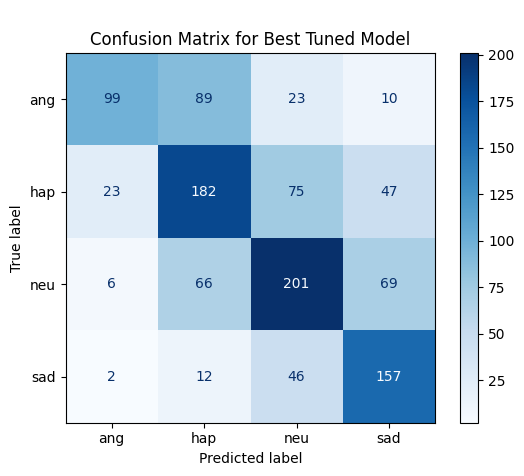

'/kaggle/working/best_cnn_model_val_acc_57.72.keras'

In [42]:
import time
mpath = f'/kaggle/working/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
            tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histcnn = cnn.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"Training took: {tm/60:.0f} min {tm%60:.0f} sec")
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = cnn.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_cnn_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [ ]:
def create_cnn_model2():
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), input_shape=(256,256,3), padding='same'))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))    
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))   
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))    
    
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, (7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))  

    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu', kernel_constraint=max_norm(2.0)))
    model.add(Dense(32, activation='relu', kernel_constraint=max_norm(2.0)))
    model.add(Dropout(0.3)) 
    model.add(Dense(len(np.unique(labelss)), activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [47]:
cnn = create_cnn_model2()
cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             

 Total params: 346,580 (1.32 MB)

 Trainable params: 346,132 (1.32 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.3068 - loss: 1.3666
Epoch 1: val_accuracy improved from -inf to 0.35050, saving model to /kaggle/working/best_cnn_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 73s 547ms/step - accuracy: 0.3072 - loss: 1.3659 - val_accuracy: 0.3505 - val_loss: 2.1635 - learning_rate: 0.0010
Epoch 2/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4067 - loss: 1.2211
Epoch 2: val_accuracy did not improve from 0.35050
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.4073 - loss: 1.2204 - val_accuracy: 0.3107 - val_loss: 4.0716 - learning_rate: 0.0010
Epoch 3/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.4692 - loss: 1.1545
Epoch 3: val_accuracy did not improve from 0.35050
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - accuracy: 0.4692 - loss: 1.1543 - val_accuracy: 0.3442 - val_loss: 1.5947 - learning_rate: 0.0010
Epoch 4/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4701 - loss: 1.1249
Epoch 4: val_accur

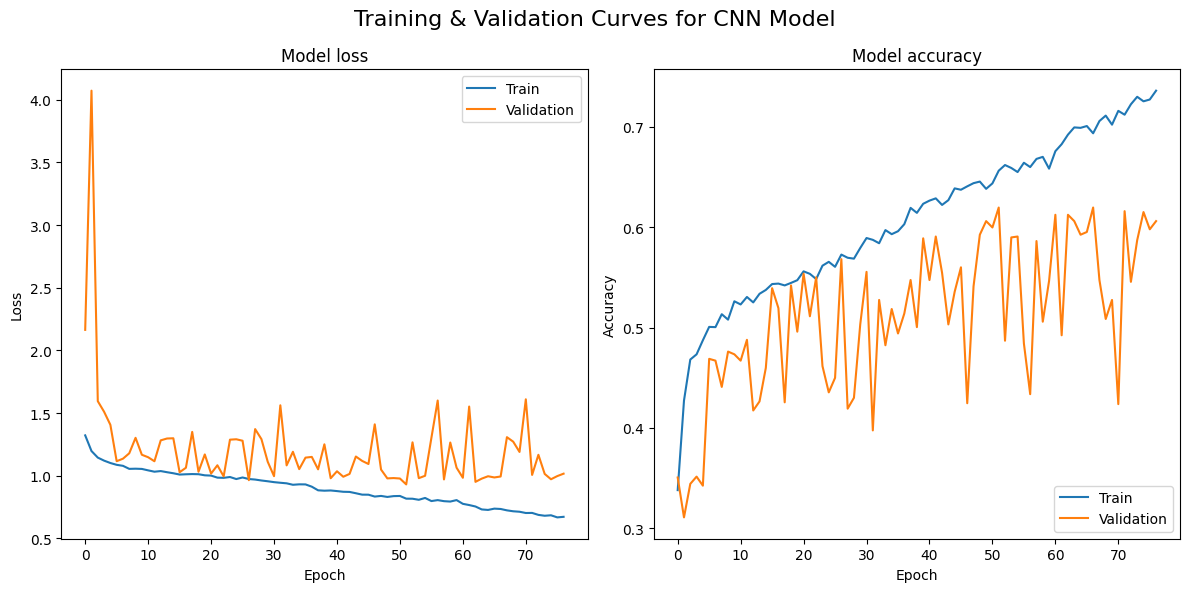

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step

Accuracy: 61.97
              precision    recall  f1-score   support

         ang       0.76      0.54      0.63       221
         hap       0.58      0.44      0.50       327
         neu       0.56      0.78      0.66       342
         sad       0.67      0.71      0.69       217

    accuracy                           0.62      1107
   macro avg       0.65      0.62      0.62      1107
weighted avg       0.63      0.62      0.61      1107



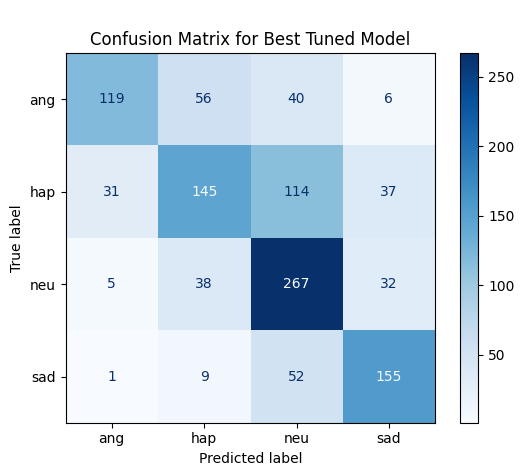

'/kaggle/working/best_cnn_model_val_acc_61.97.keras'

In [48]:
import time
mpath = f'/kaggle/working/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
            tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histcnn = cnn.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"Training took: {tm/60:.0f} min {tm%60:.0f} sec")
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = cnn.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_cnn_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [22]:
def create_cnn_model3():
    model = Sequential()
    initializer = tf.keras.initializers.he_normal()
    regularizer = tf.keras.regularizers.l2(l2=0.01)
    constraint  = tf.keras.constraints.MaxNorm(max_value=2)
    model.add(Conv2D(16, (3, 3), input_shape=(256,256,3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))   
    model.add(Conv2D(16, (3, 3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))  
    
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(labelss)), activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [23]:
cnn = create_cnn_model3()
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64, 64, 64)     │             

 Total params: 346,580 (1.32 MB)

 Trainable params: 346,132 (1.32 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
import time
mpath = f'/kaggle/working/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
            tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histcnn = cnn.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"\nTraining took: {tm/60:.0f} min {tm%60:.0f} sec")

Epoch 1/500


2024-09-23 12:24:52.905529: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,128,128]{3,2,1,0}, f32[32,32,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-23 12:24:52.923828: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.018399251s
Trying algorithm eng0{} for conv (f32[128,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,128,128]{3,2,1,0}, f32[32,32,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_c

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3215 - loss: 6.2573   
Epoch 1: val_accuracy improved from -inf to 0.30894, saving model to /kaggle/working/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.3224 - loss: 6.2347 - val_accuracy: 0.3089 - val_loss: 4.2505 - learning_rate: 0.0010
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.4047 - loss: 3.6033
Epoch 2: val_accuracy improved from 0.30894 to 0.42909, saving model to /kaggle/working/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - accuracy: 0.4052 - loss: 3.5953 - val_accuracy: 0.4291 - val_loss: 2.9097 - learning_rate: 0.0010
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4368 - loss: 2.6852
Epoch 3: val_accuracy did not improve from 0.42909
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 0.4371 - loss: 2.6820 - val_accuracy: 0.2349 - val_loss: 2.5703 - learning_rate: 0.0010
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accura

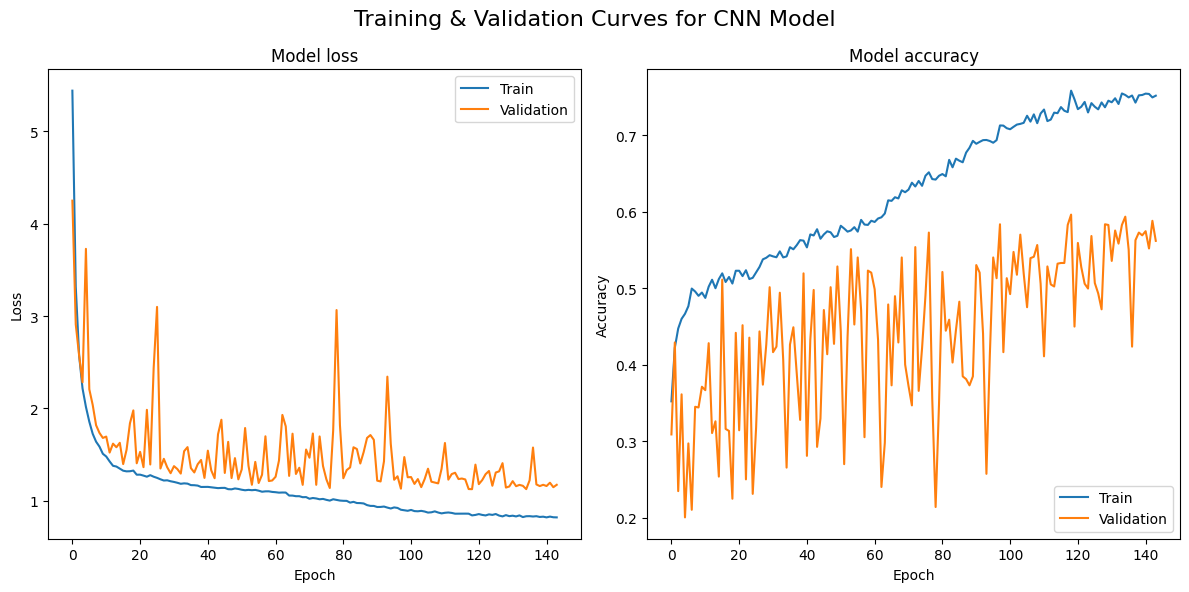

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step

Accuracy: 59.62
              precision    recall  f1-score   support

         ang       0.63      0.62      0.63       221
         hap       0.53      0.49      0.51       327
         neu       0.59      0.61      0.60       342
         sad       0.65      0.70      0.67       217

    accuracy                           0.60      1107
   macro avg       0.60      0.61      0.60      1107
weighted avg       0.59      0.60      0.59      1107



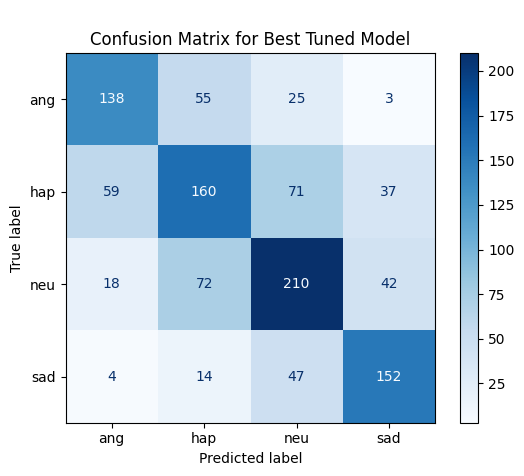

'/kaggle/working/best_cnn_model_val_acc_59.62.keras'

In [25]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = cnn.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_cnn_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [32]:
def create_cnn_model4():
    model = Sequential()
    initializer = tf.keras.initializers.he_normal()
    regularizer = tf.keras.regularizers.l2(l2=0.01)
    constraint  = tf.keras.constraints.MaxNorm(max_value=2)
    model.add(Conv2D(16, (3, 3), input_shape=(256,256,3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))   
    model.add(Conv2D(16, (3, 3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))  
    
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(32, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, (9, 9), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (9, 9), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(labelss)), activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
    
    return model

In [33]:
cnn = create_cnn_model4()
cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 64, 64, 32)     │             

 Total params: 643,860 (2.46 MB)

 Trainable params: 643,284 (2.45 MB)

 Non-trainable params: 576 (2.25 KB)

In [34]:
import time
mpath = f'/kaggle/working/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.000001),
            tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histcnn = cnn.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"\nTraining took: {tm/60:.0f} min {tm%60:.0f} sec")

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.2930 - loss: 8.6098
Epoch 1: val_accuracy improved from -inf to 0.23216, saving model to /kaggle/working/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2937 - loss: 8.6040 - val_accuracy: 0.2322 - val_loss: 21.4990 - learning_rate: 1.0000e-04
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.3496 - loss: 7.9881
Epoch 2: val_accuracy improved from 0.23216 to 0.34237, saving model to /kaggle/working/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 502ms/step - accuracy: 0.3501 - loss: 7.9851 - val_accuracy: 0.3424 - val_loss: 10.4113 - learning_rate: 1.0000e-04
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.3723 - loss: 7.5701
Epoch 3: val_accuracy did not improve from 0.34237
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.3726 - loss: 7.5671 - val_accuracy: 0.2584 - val_loss: 7.4047 - learning_rate: 1.0000e-04
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━

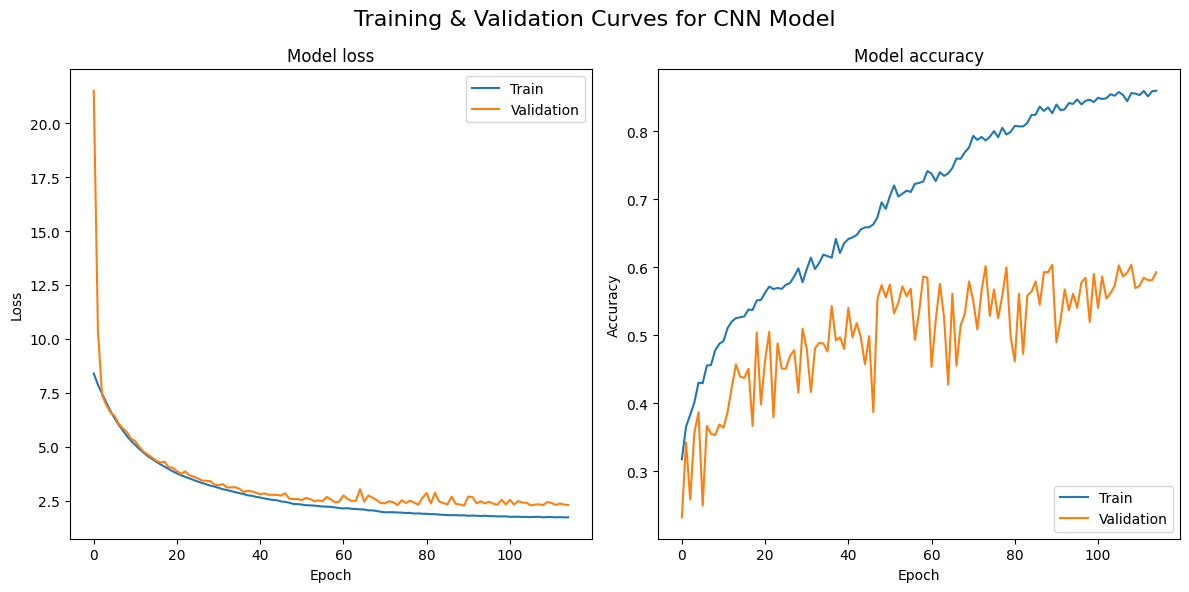

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step

Accuracy: 60.34
              precision    recall  f1-score   support

         ang       0.69      0.62      0.65       221
         hap       0.56      0.59      0.57       327
         neu       0.57      0.66      0.61       342
         sad       0.68      0.53      0.59       217

    accuracy                           0.60      1107
   macro avg       0.62      0.60      0.61      1107
weighted avg       0.61      0.60      0.60      1107



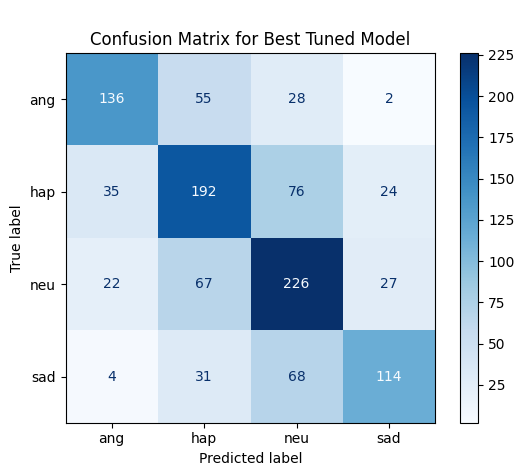

'/kaggle/working/best_cnn_model_val_acc_60.34.keras'

In [35]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = cnn.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_cnn_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [39]:
def create_cnn_model5():
    model = Sequential()
    initializer = tf.keras.initializers.he_normal()
    regularizer = tf.keras.regularizers.l2(l2=0.01)
    constraint  = tf.keras.constraints.MaxNorm(max_value=2)
    model.add(Conv2D(16, (3, 3), input_shape=(256,256,3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))   
    model.add(Conv2D(16, (3, 3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))  
    
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(32, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (7, 7), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, (9, 9), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (9, 9), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (9, 9), padding='same',
              kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dense(32, activation='relu',
                    kernel_initializer=initializer,kernel_regularizer=regularizer,kernel_constraint=constraint))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(labelss)), activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
    
    return model

In [40]:
cnn = create_cnn_model5()
cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 64, 32)     │             

 Total params: 1,054,436 (4.02 MB)

 Trainable params: 1,053,572 (4.02 MB)

 Non-trainable params: 864 (3.38 KB)

In [42]:
import time
mpath = f'/kaggle/working/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.000001),
            tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histcnn = cnn.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"\nTraining took: {tm/60:.0f} min {tm%60:.0f} sec")

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3467 - loss: 11.0499   
Epoch 1: val_accuracy improved from -inf to 0.31978, saving model to /kaggle/working/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3469 - loss: 11.0440 - val_accuracy: 0.3198 - val_loss: 11.0226 - learning_rate: 1.0000e-04
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.3886 - loss: 10.1829
Epoch 2: val_accuracy did not improve from 0.31978
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 797ms/step - accuracy: 0.3886 - loss: 10.1774 - val_accuracy: 0.2972 - val_loss: 9.7539 - learning_rate: 1.0000e-04
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.4093 - loss: 9.3716
Epoch 3: val_accuracy did not improve from 0.31978
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 795ms/step - accuracy: 0.4093 - loss: 9.3669 - val_accuracy: 0.2990 - val_loss: 8.9714 - learning_rate: 1.0000e-04
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.4358 - loss: 8.6627
Epoc

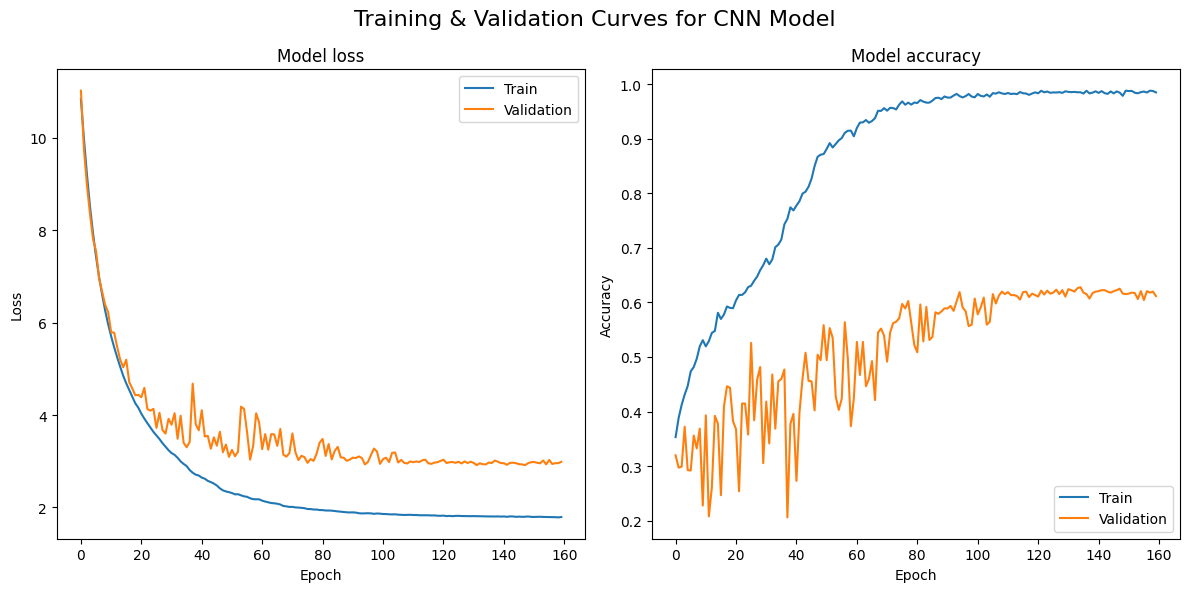

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step

Accuracy: 62.78
              precision    recall  f1-score   support

         ang       0.76      0.66      0.71       221
         hap       0.63      0.56      0.59       327
         neu       0.62      0.58      0.60       342
         sad       0.56      0.77      0.65       217

    accuracy                           0.63      1107
   macro avg       0.64      0.64      0.64      1107
weighted avg       0.64      0.63      0.63      1107



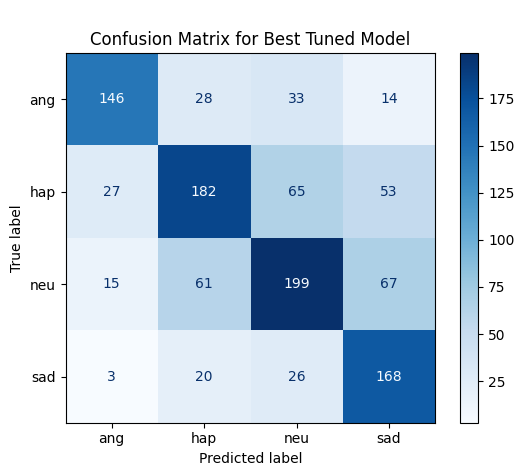

'/kaggle/working/best_cnn_model_val_acc_62.78.keras'

In [43]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = cnn.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_cnn_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.regularizers import l2
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

resnet = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

for layer in base_model.layers[-15:]:
  layer.trainable = True

resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.summary(show_trainable=True)

Model: "functional_244"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_14    │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 262,     │         0 │ input_layer_1… │   -   │
│ (ZeroPadding2D)   │ 262, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 128,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 128,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 128,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 130,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 130, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 64, 64,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 64, 64,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 64, 64,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 64, 64,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 64, 64,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 64, 64,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 64, 64,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 64, 64,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 64, 64,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 64, 64,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 64, 64,  │     1,024 │ conv2_block1_… │   N 

 Total params: 23,655,524 (90.24 MB)

 Trainable params: 5,588,196 (21.32 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [60]:
mpath = '/kaggle/working/best_resnet50_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.000001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histresnet = resnet.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"\nTraining took: {tm/60:.0f} min {tm%60:.0f} sec")

Epoch 1/500
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2567 - loss: 2.7019
Epoch 1: val_accuracy improved from -inf to 0.33604, saving model to /kaggle/working/best_resnet50_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 53s 247ms/step - accuracy: 0.2569 - loss: 2.7011 - val_accuracy: 0.3360 - val_loss: 2.4460 - learning_rate: 1.0000e-04
Epoch 2/500
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3599 - loss: 2.4083
Epoch 2: val_accuracy improved from 0.33604 to 0.40199, saving model to /kaggle/working/best_resnet50_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.3600 - loss: 2.4078 - val_accuracy: 0.4020 - val_loss: 2.2724 - learning_rate: 1.0000e-04
Epoch 3/500
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3996 - loss: 2.2488
Epoch 3: val_accuracy improved from 0.40199 to 0.47967, saving model to /kaggle/working/best_resnet50_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.3996 - loss: 2.2484 - val_accuracy: 0.47

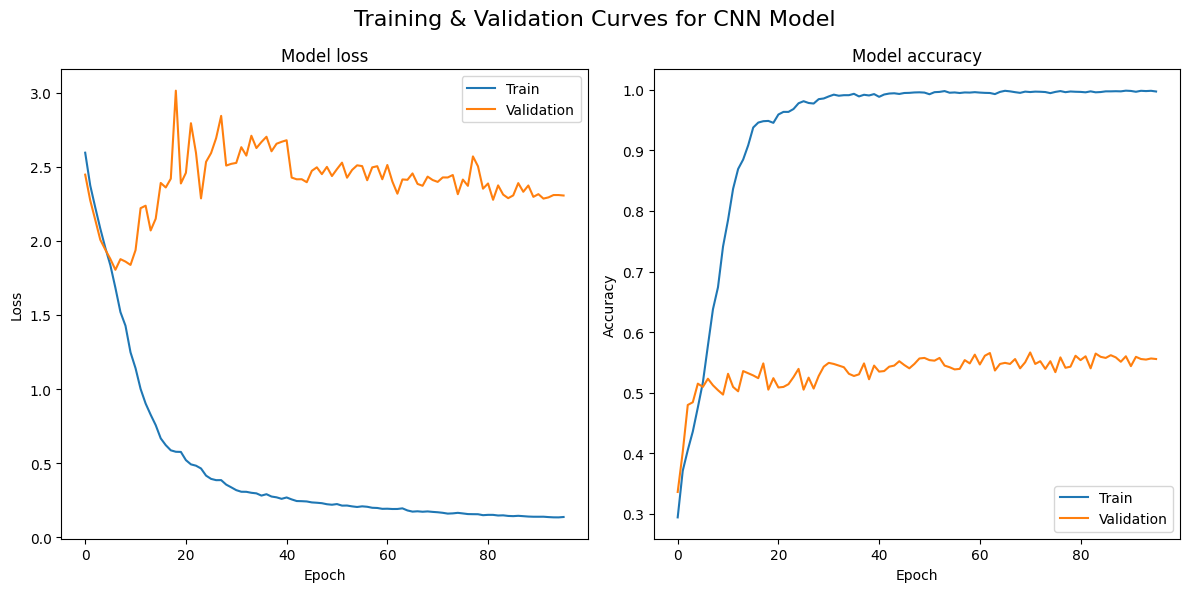

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step

Accuracy: 56.64
              precision    recall  f1-score   support

         ang       0.63      0.59      0.61       221
         hap       0.51      0.54      0.53       327
         neu       0.54      0.53      0.54       342
         sad       0.63      0.64      0.63       217

    accuracy                           0.57      1107
   macro avg       0.58      0.57      0.58      1107
weighted avg       0.57      0.57      0.57      1107



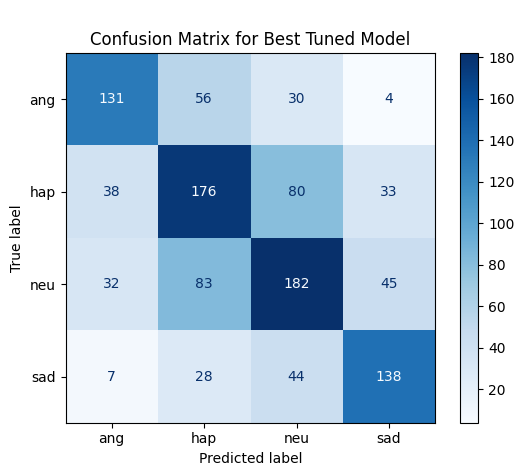

'/kaggle/working/best_resnet50_model_val_acc_56.64.keras'

In [61]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for CNN Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histresnet.history['loss'])
plt.plot(histresnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histresnet.history['accuracy'])
plt.plot(histresnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

predictions = resnet.predict(X_test)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))
accuracy = accuracy_score(y_true,predicted_labels)
print('\nAccuracy: %.2f' % (accuracy*100))
print(classification_report(y_true, predicted_labels))
cm = confusion_matrix(y_true, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'\nConfusion Matrix for Best Tuned Model')
plt.show()
new_mpath = f"/kaggle/working/best_resnet50_model_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

In [63]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu',kernel_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

resnet = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

for layer in base_model.layers[-7:]:
  layer.trainable = True

resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.summary(show_trainable=True)

Model: "functional_248"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_16    │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 262,     │         0 │ input_layer_1… │   -   │
│ (ZeroPadding2D)   │ 262, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 128,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 128,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 128,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 130,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 130, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 64, 64,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 64, 64,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 64, 64,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 64, 64,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 64, 64,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 64, 64,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 64, 64,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 64, 64,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 64, 64,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 64, 64,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 64, 64,  │     1,024 │ conv2_block1_… │   N 

 Total params: 23,620,564 (90.11 MB)

 Trainable params: 3,448,404 (13.15 MB)

 Non-trainable params: 20,172,160 (76.95 MB)

In [64]:
mpath = '/kaggle/working/best_resnet50_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.000001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
st = time.time()
histresnet = resnet.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)
en = time.time()
tm = en-st
print(f"\nTraining took: {tm/60:.0f} min {tm%60:.0f} sec")

Epoch 1/500
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3224 - loss: 4.3366
Epoch 1: val_accuracy improved from -inf to 0.42096, saving model to /kaggle/working/best_resnet50_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.3225 - loss: 4.3341 - val_accuracy: 0.4210 - val_loss: 3.3543 - learning_rate: 1.0000e-04
Epoch 2/500
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3936 - loss: 3.1504
Epoch 2: val_accuracy improved from 0.42096 to 0.48780, saving model to /kaggle/working/best_resnet50_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.3938 - loss: 3.1477 - val_accuracy: 0.4878 - val_loss: 2.5663 - learning_rate: 1.0000e-04
Epoch 3/500
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4549 - loss: 2.4300
Epoch 3: val_accuracy did not improve from 0.48780
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.4549 - loss: 2.4283 - val_accuracy: 0.4860 - val_loss: 2.0958 - learning_rate: 1.0000e-04
Epoch 4/500
1

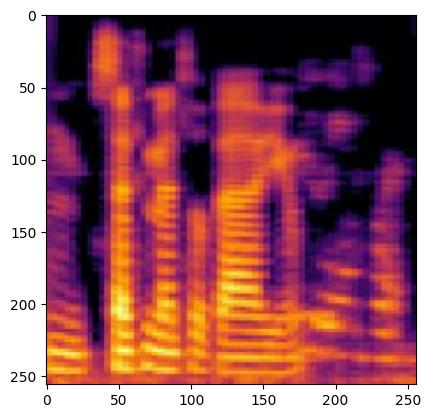

In [110]:
plt.imshow(X_train[55])

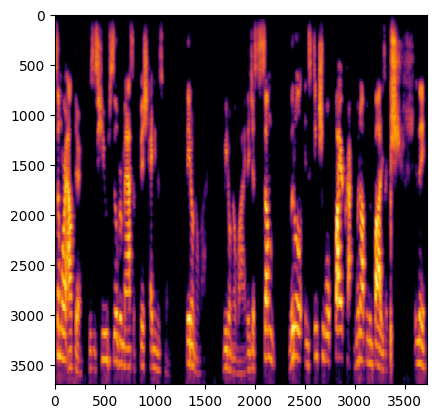

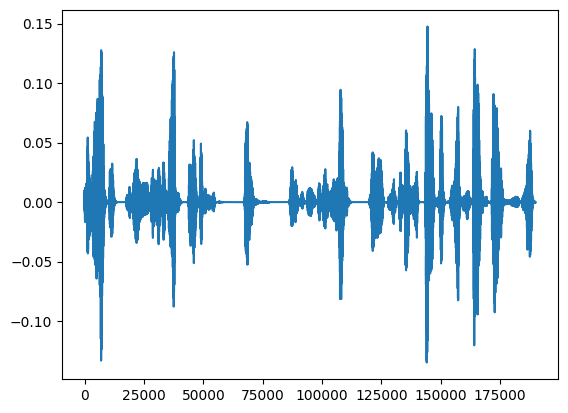

hap


In [144]:
dpath = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session3/sentences/wav/'
randf = np.random.choice(os.listdir(dpath))
path2 = os.path.join(dpath,randf)
randw = np.random.choice(os.listdir(path2))
audio_path = os.path.join(path2,randw)
image,audio = load_preprocess_extract_specs(audio_path)
plt.plot(audio)
plt.show()
print(labdict[randw])
ipd.Audio(audio,rate=16000)